In [1]:
# file:///C:/cllg/nural%20networks/eyeTracker/canvas/index.html

In [1]:
import cv2
import mediapipe as mp
import pyautogui
import numpy as np
import time

import tensorflow as tf
from keras.models import Model
from keras import Sequential,layers,optimizers,losses,activations
# import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

# DATA

In [2]:
x = []
nx = []
y = []

In [5]:
screen_w, screen_h = pyautogui.size()

inpimg = (50,50)

In [14]:
move_duration = 0.2
sleep = 0.3
movemouse = True

cam = cv2.VideoCapture(0)
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)
pyautogui.hotkey('alt', 'tab')



while True:
    
    mx , my = pyautogui.position()
    

    if(movemouse):
        mx = np.random.randint(10,screen_w-10)
        my = np.random.randint(10,screen_h-10)

        pyautogui.moveTo(mx,my,move_duration)
    
    time.sleep(sleep)
    
    _, frame = cam.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output = face_mesh.process(rgb_frame)
    landmark_points = output.multi_face_landmarks
    frame_h, frame_w, _ = frame.shape
               
    if landmark_points:
        
#         for landmark in [landmarks[159],landmarks[475]]:
#             px = int(landmark.x * frame_w)
#             py = int(landmark.y * frame_h)
#             cv2.circle(frame, (px, py), 2, (255, 255, 255))
            
            
        landmarks = landmark_points[0].landmark
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        frame1_crop = frame[int(landmarks[257].y * frame_h):int(landmarks[253].y * frame_h), int(landmarks[362].x * frame_w):int(landmarks[359].x * frame_w)]
        frame1_crop = cv2.resize(frame1_crop,(inpimg[0],inpimg[1]))
        
        frame2_crop = frame[int(landmarks[27].y * frame_h):int(landmarks[23].y * frame_h), int(landmarks[130].x * frame_w):int(landmarks[243].x * frame_w)]
        frame2_crop = cv2.resize(frame2_crop,(inpimg[0],inpimg[1]))
        
        frame_resized = cv2.resize(frame,(inpimg[0],inpimg[1]))
        
        
        x.append([frame_resized,frame1_crop,frame2_crop])
        nx.append(np.array([landmarks[168].x,landmarks[168].y,landmarks[168].z]))
        y.append(np.array([mx,my]))
        
        print(f"\r{len(x), mx,my , landmarks[168].x,landmarks[168].y,landmarks[168].z}           ", end="")
            
    cv2.imshow('Eye_Tracker', frame)
    k = cv2.waitKey(1)
    
    if k == 27:
        print("\ndone")
        cv2.destroyAllWindows()
        cam.release()
        pyautogui.hotkey('alt', 'tab')
        break

(448, 523, 683, 0.5013309121131897, 0.4994794726371765, -0.03182473033666611)               
done


In [15]:
len(x)

448

In [16]:
cv2.destroyAllWindows()
cam.release()

In [17]:
# toRemove = 10
# x = x[:-toRemove]
# y = y[:-toRemove]
# nx = nx[:-toRemove]

In [18]:
i = len(x) - 1

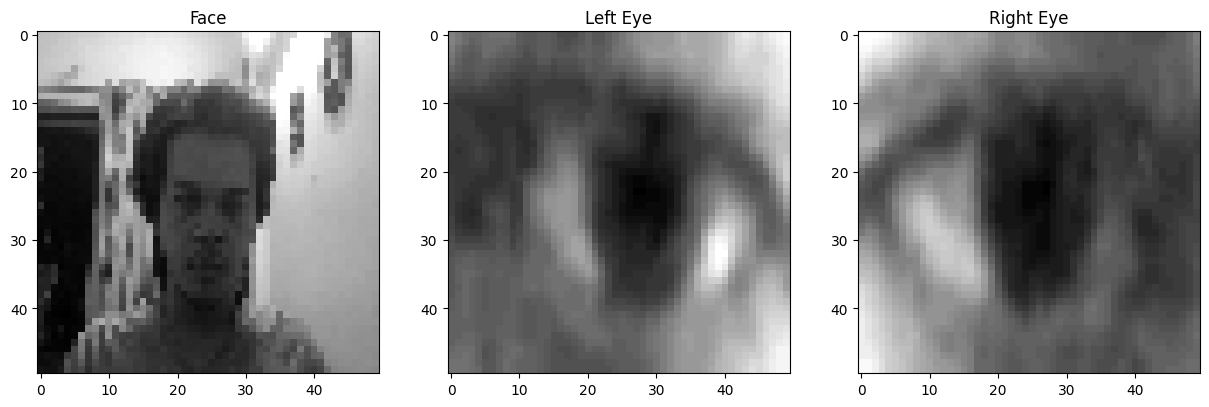

446 [ 0.51012546  0.49728882 -0.02865727] [1556  577]


In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x[i][0],cmap="gray")
ax[0].set_title("Face")

ax[1].imshow(x[i][1],cmap="gray")
ax[1].set_title("Left Eye")

ax[2].imshow(x[i][2],cmap="gray")
ax[2].set_title("Right Eye")

plt.show()

print(i,nx[i],y[i])
i -= 1

In [23]:
dx = np.array(x)
dnx = np.array(nx)
dy = np.array(y)

In [24]:
# def random_brightness_contrast(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
#     alpha = np.random.uniform(alpha_range[0], alpha_range[1])
#     beta = np.random.uniform(beta_range[0], beta_range[1])
#     adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
#     return adjusted_image

In [25]:
# for curr,i in enumerate(dx):
#     print(f"\r{curr}           ",end="")
#     for j in range(3):
#         dx = np.append(dx,[random_brightness_contrast(i)],axis=0)
#         dnx = np.append(dnx,[dnx[curr]],axis=0)
#         dy = np.append(dy,[dy[curr]],axis=0)

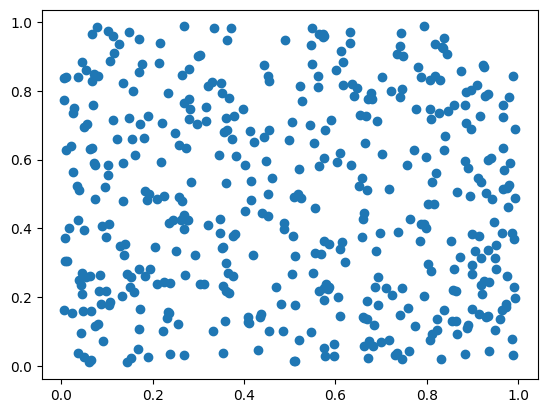

In [36]:
plt.scatter(dy[:,0],dy[:,1])

In [35]:
dx.shape,dy.shape

((448, 3, 50, 50), (448, 2))

In [27]:
dy = (dy/[screen_w, screen_h])
dx = dx/255

In [28]:
p = np.random.permutation(dy.shape[0])
dx = dx[p]
dnx = dnx[p]
dy = dy[p]

# MODEL

In [37]:
# Conv Layers
def convLayers(img):
    conv = layers.Conv2D(8,(3,3),activation=activations.leaky_relu)(img)
    conv = layers.Conv2D(16,(3,3),activation=activations.leaky_relu)(conv)
    maxp = layers.MaxPooling2D((2,2))(conv)

    conv = layers.Conv2D(32,(3,3),activation=activations.leaky_relu)(maxp)
    conv = layers.Conv2D(64,(3,3),activation=activations.leaky_relu)(conv)
    maxp = layers.MaxPooling2D((2,2))(conv)

    conv = layers.Conv2D(128,(3,3),activation=activations.leaky_relu)(maxp)
    conv = layers.Conv2D(256,(3,3),activation=activations.leaky_relu)(conv)
    maxp = layers.MaxPooling2D((2,2))(conv)
    
    return maxp


# img1
image_input1 = layers.Input(shape=inpimg+(1,))

flat1 = layers.Flatten()(convLayers(image_input1))


# img2
image_input2 = layers.Input(shape=inpimg+(1,))

flat2 = layers.Flatten()(convLayers(image_input2))



# img3
image_input3 = layers.Input(shape=inpimg+(1,))

flat3 = layers.Flatten()(convLayers(image_input3))


# pos INP
pos_input = layers.Input(shape=(3,))


# dense
concat = layers.Concatenate()([ flat1, flat2, flat3, pos_input ])

dense = layers.Dense(128,activation = activations.leaky_relu)(concat)
dense = layers.Dense(128,activation = activations.leaky_relu)(dense)
dense = layers.Dense(64,activation = activations.leaky_relu)(dense)
output = layers.Dense(2)(dense)

model = Model(inputs = [image_input1,image_input2,image_input3,pos_input], outputs = output)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 50, 50, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 50, 50, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 50, 50, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 48, 48, 8)         │              80 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 48, 48, 8)         │              80 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_30 (Conv2D)            │ (None, 48, 48, 8)         │              80 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 46, 46, 16)        │           1,168 │ conv2d_18[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 46, 46, 16)        │           1,168 │ conv2d_24[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_31 (Conv2D)            │ (None, 46, 46, 16)        │           1,168 │ conv2d_30[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 23, 23, 16)        │               0 │ conv2d_19[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 23, 23, 16)        │               0 │ conv2d_25[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 23, 23, 16)        │               0 │ conv2d_31[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 21, 21, 32)        │           4,640 │ max_pooling2d_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 21, 21, 32)        │           4,640 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_32 (Conv2D)            │ (None, 21, 21, 32)        │           4,640 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 19, 19, 64)        │          18,49

 Total params: 1,598,850 (6.10 MB)

 Trainable params: 1,598,850 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

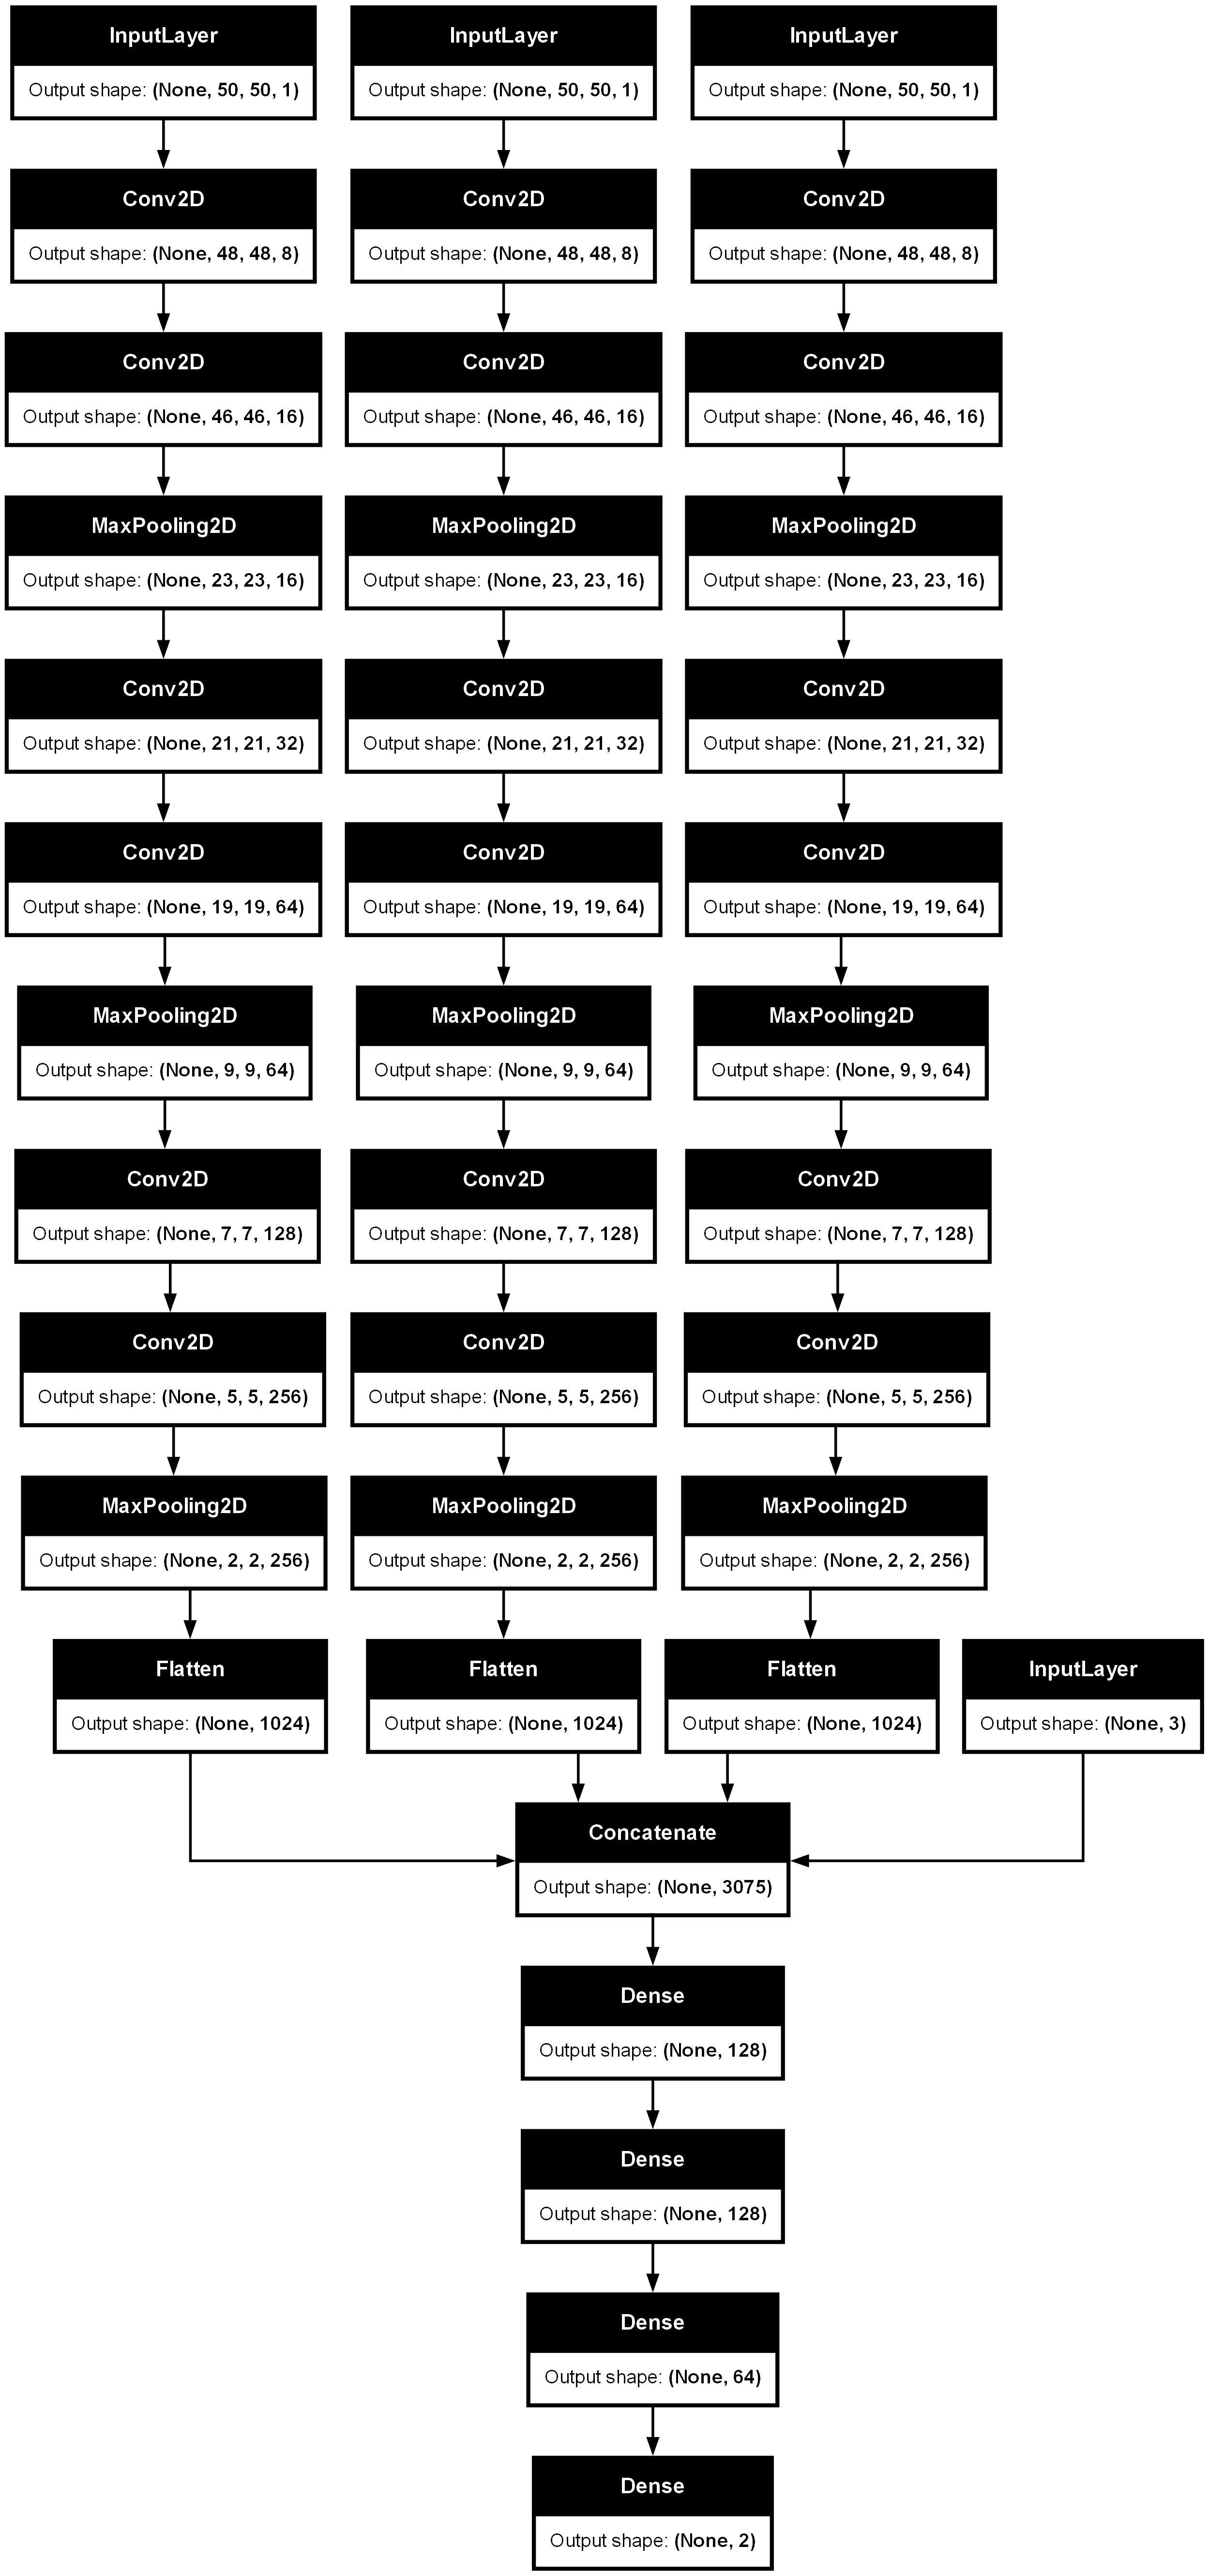

In [38]:
# plot_model(model,to_file=r"C:\cllg\nural networks\eyeTracker\research paper\architecture.png",show_shapes=True)

In [39]:
model.compile(loss = tf.losses.mse , optimizer= optimizers.Adam(1e-4))

In [40]:
ES = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [41]:
hist = model.fit([dx[:,0],dx[:,1],dx[:,2],dnx],dy,batch_size=16,epochs=1000,validation_split=.2,shuffle=True, callbacks=[ES])

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.2598 - val_loss: 0.0960
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0905 - val_loss: 0.0928
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0837 - val_loss: 0.0969
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0816 - val_loss: 0.0874
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0801 - val_loss: 0.0742
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0658 - val_loss: 0.0529
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0475 - val_loss: 0.0501
Epoch 8/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0471 - val_loss: 0.0494
Epoch 9/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0467 - val_loss: 0.0490
Epoch 10/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0407 - val_loss: 0.0463
Epoch 11/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0424 - val_loss: 0.0442
Epoch 12/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 

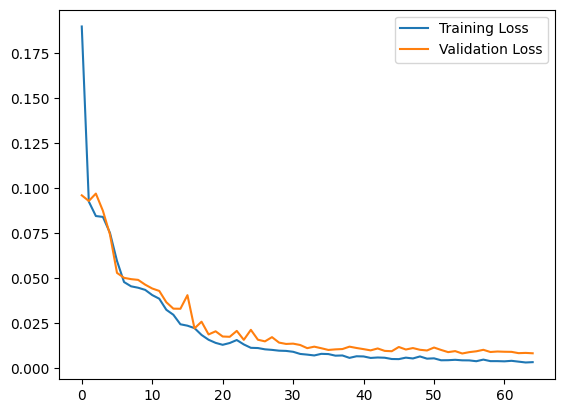

In [42]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(["Training Loss", "Validation Loss"])
plt.show()


In [43]:
i = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
pred: [0.09775046 0.22077815] 
 actual: [0.0453125  0.20925926]


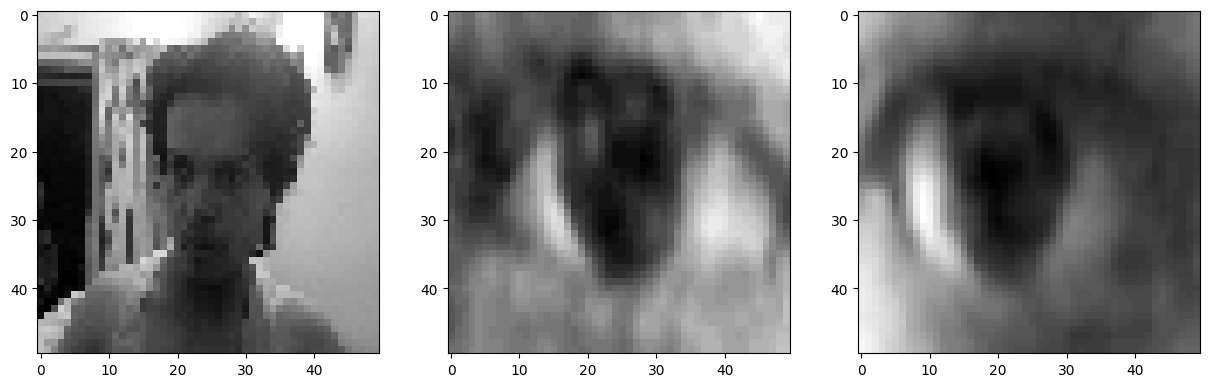

In [44]:
print(f"pred: {model.predict([np.array([dx[i,0]]),np.array([dx[i,1]]),np.array([dx[i,2]]),np.array([dnx[i]])])[0]} \n actual: {dy[i]}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(dx[i][0],cmap="gray")
ax[1].imshow(dx[i][1],cmap="gray")
ax[2].imshow(dx[i][2],cmap="gray")
plt.show()
i += 1

In [50]:
pyautogui.FAILSAFE = False

In [53]:
cam = cv2.VideoCapture(0)
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

while True:
    _, frame = cam.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output = face_mesh.process(rgb_frame)
    landmark_points = output.multi_face_landmarks
               
    if landmark_points:
        
#         for landmark in [landmarks[159],landmarks[475]]:
#             px = int(landmark.x * frame_w)
#             py = int(landmark.y * frame_h)
#             cv2.circle(frame, (px, py), 2, (255, 255, 255))
        
        landmarks = landmark_points[0].landmark
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        frame1_crop = frame[int(landmarks[257].y * frame_h):int(landmarks[253].y * frame_h), int(landmarks[362].x * frame_w):int(landmarks[359].x * frame_w)]
        frame1_crop = cv2.resize(frame1_crop,(inpimg[0],inpimg[1]))
        
        frame2_crop = frame[int(landmarks[27].y * frame_h):int(landmarks[23].y * frame_h), int(landmarks[130].x * frame_w):int(landmarks[243].x * frame_w)]
        frame2_crop = cv2.resize(frame2_crop,(inpimg[0],inpimg[1]))
        
        frame_resized = cv2.resize(frame,(inpimg[0],inpimg[1]))
        
        
        pos = np.array([landmarks[168].x,landmarks[168].y,landmarks[168].z])
        
        mx, my = model.predict([np.array([frame_resized/255]),np.array([frame1_crop/255]),np.array([frame2_crop/255]), np.array([pos])],verbose=0)[0]
        
        omx = int(mx * screen_w)
        
        omy = int(my * screen_h)
        
        pyautogui.moveTo(omx, omy, duration=0.2)
        
        print(f"\r{mx,my} {omx,omy} {pos}      ", end="")
            
    cv2.imshow('Eye_Tracker', frame)
    
    k = cv2.waitKey(1)
    
    if k == 27:
        print("\ndone")
        cv2.destroyAllWindows()
        cam.release()
        break

(0.9986667, 0.043654434) (1917, 47) [ 0.53466272  0.46933353 -0.01807942]         
done


In [46]:
cv2.destroyAllWindows()
cam.release()

# SAVE

In [54]:
path = "C://cllg//nural networks//eyeTracker//"

In [55]:
np.save(path+"x.npy",x)
np.save(path+"nx.npy",nx)
np.save(path+"y.npy",y)

In [56]:
from datetime import datetime

current_datetime = str(datetime.now())
f"{current_datetime.split()[0]}_{current_datetime.split()[1][:8].replace(':','-')}"

'2024-05-03_21-35-10'

In [57]:
model.save(path+"eyeTracker.keras")
model.save(path+f"models//eyeTracker v{current_datetime.split()[0]}_{current_datetime.split()[1][:8].replace(':','-')}.keras")

# LOAD

In [3]:
path = "C://cllg//nural networks//eyeTracker//"

In [4]:
x = list(np.load(path+"x.npy"))
nx = list(np.load(path+"nx.npy"))
y = list(np.load(path+"y.npy"))
len(x)

335

In [4]:
model = tf.keras.models.load_model(f"{path}eyeTracker.h5")

# Facial Landmarks

In [6]:
# import cv2
# import mediapipe as mp

# # Initialize Mediapipe Face Detection
# mp_face_mesh = mp.solutions.face_mesh
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.1)

# # Load and preprocess grayscale image
# cam = cv2.VideoCapture(0)
# _, frame = cam.read()
# height, width = frame.shape[:2]
# # Detect facial landmarks
# results = face_mesh.process(frame)

# # Draw landmarks on the image
# if results.multi_face_landmarks:
#     for face_landmarks in results.multi_face_landmarks:
#         for idx, landmark in enumerate(face_landmarks.landmark):
#             cx, cy = int(landmark.x * width), int(landmark.y * height)
#             cv2.circle(frame, (cx, cy), 2, (0, 255, 0), -1)

# grayimg = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
# # Display the image with landmarks
# plt.imshow(frame[:,:,::-1])
# cv2.destroyAllWindows()
# cam.release()